In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset # for loading dataset (mnist)
import torchvision.transforms as transforms # for processing datasets
from torch.utils.data import DataLoader # for making dataset easier to use 

from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: gpu") if torch.cuda.is_available() else print("device: cpu")

device: gpu


In [0]:
# hypter parameter setting
learning_rate = 1e-4
training_epochs = 100
display_step = 10
batch_size = 64

activation = nn.ReLU()
max_pool = nn.MaxPool2d(2,2) # kerel size, stride size, padding size 
dropout_rate = .2 # probability to be 0 

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


len(train_data):  50000
len(test_data):  10000
data tensor([[[-0.5373, -0.5137, -0.5059],
         [-0.6627, -0.6392, -0.6471],
         [-0.6078, -0.6235, -0.6627],
         ...,
         [ 0.2392,  0.0353, -0.1529],
         [ 0.1922, -0.0196, -0.2000],
         [ 0.1608, -0.0275, -0.1922]],

        [[-0.8745, -0.8431, -0.8431],
         [-1.0000, -1.0000, -1.0000],
         [-0.8588, -0.9373, -1.0000],
         ...,
         [-0.0353, -0.3098, -0.5686],
         [-0.0667, -0.3490, -0.6078],
         [-0.0431, -0.3176, -0.5529]],

        [[-0.8039, -0.8118, -0.8353],
         [-0.8745, -0.9451, -1.0000],
         [-0.6157, -0.7882, -0.9373],
         ...,
         [-0.0745, -0.3412, -0.6078],
         [-0.0588, -0.3412, -0.6078],
         [-0.1451, -0.4275, -0.6706]],

        ...,

        [[ 0.6314,  0.3333, -0.2471],
         [ 0.5765,  0.2000, -0.7333],
         [ 0.5529,  0.2627, -0.7961],
         ...,
         [ 0.2549,  0.0431, -0.4510],
         [-0.5608, -0.7569, -0.9451]

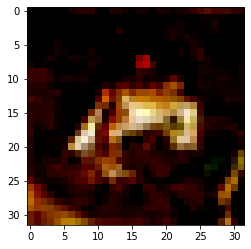

In [31]:
# load data
import numpy as np
train_data = dataset.CIFAR10("./", train = True,  transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5,),   
                                         std=(0.5,))]), target_transform = None, download = True)
test_data = dataset.CIFAR10("./", train = False,  transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5,),   
                                         std=(0.5,))]), target_transform = None, download = True)

# check the data
print('len(train_data): ', len(train_data))
print('len(test_data): ', len(test_data))

x_train, y_train = train_data[0]
x_train = np.transpose(x_train, (1, 2, 0))  # 3 X 32 X 32 -> 32 X 32 X 3 으로 바꾼거임

print('data', x_train)
print('data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


data shape: torch.Size([64, 3, 32, 32])
label: tensor([1, 1, 9, 4, 0, 6, 2, 4, 2, 1, 2, 5, 8, 9, 3, 1, 5, 4, 3, 3, 1, 2, 6, 2,
        3, 7, 2, 7, 8, 7, 3, 0, 6, 4, 1, 1, 8, 8, 3, 6, 3, 0, 6, 7, 5, 1, 7, 4,
        6, 5, 2, 3, 5, 5, 2, 1, 8, 4, 7, 1, 2, 0, 1, 9])


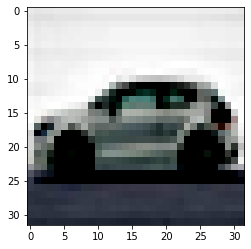

In [32]:
# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)

# check the data 
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('data shape:', example_data.shape)
print('label:', example_target)

check_image = example_data[0]
check_image = np.transpose(check_image, (1, 2, 0))

plt.figure()
plt.imshow(check_image)
plt.show()

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # for initializing nn.Module (parent class)
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(3, 16, 5), #16 X 28 X 28
            nn.BatchNorm2d(16),
            activation,          # we can set stride size and padding size. if we do not set the these parameters, default value is 1, 0.
            nn.Dropout(dropout_rate),

            nn.Conv2d(16, 32,5), # 32 X 24 X 24
            nn.BatchNorm2d(32),
            activation,
            nn.Dropout(dropout_rate),

            nn.Conv2d(32,64,5), #64 X 20 X 20
            nn.BatchNorm2d(64),
            activation,         


            nn.Conv2d(64,64,5), #64 X 16 X 16
            activation,         
            max_pool,             # 64 X 8 X 8
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_rate)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 100),
            activation,
            nn.Dropout(0.5),
            nn.Linear(100, 10)
        )
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) # [32, 64, 4, 4]
        flatten = extracted_feature.view(batch_size, -1) # [32, 64 * 4 * 4]
        result = self.classifier(flatten)
        return result

model = CNN().to(device)
model.train()

loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [36]:
loss_array = []

# train the model
#500에폭한번 돌리고
#다시 한번더 돌린 결과창입니다.
for i in range(training_epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        loss_array.append(loss.cpu().detach().numpy())

0 epoch loss: 1.4511010646820068
10 epoch loss: 0.7452864050865173
20 epoch loss: 1.024077296257019
30 epoch loss: 0.5661655068397522
40 epoch loss: 0.40823760628700256
50 epoch loss: 0.4683587849140167
60 epoch loss: 0.3939458131790161
70 epoch loss: 0.3027421832084656
80 epoch loss: 0.5376462936401367
90 epoch loss: 0.268332839012146


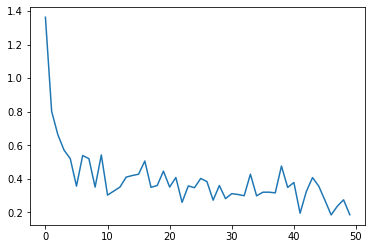

In [19]:
#첫 500에폭 Plot입니다.
plt.figure()
plt.plot(loss_array)
plt.show()

In [37]:
#test the model
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for index, [data, label] in enumerate(test_loader):
        data = data.to(device)
        label = label.to(device)
        
        output = model.forward(data)
        _, prediction_index = torch.max(output, 1)
        
        prediction_list.append(prediction_index)
        label_list.append(label)
        
        total += label.size(0)
        correct += (prediction_index == label).sum().float()

    print("Accuracy of the model: {}".format(correct/total))

Accuracy of the model: 0.7677283883094788


In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # for initializing nn.Module (parent class)
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(3, 96, 3,padding =1), #96 X 32 X 32
            nn.BatchNorm2d(96),
            activation,          # we can set stride size and padding size. if we do not set the these parameters, default value is 1, 0.
            nn.Dropout(dropout_rate),

            nn.Conv2d(96, 96, 3,padding =1), #96 X 32 X 32
            nn.BatchNorm2d(96),
            activation,          # we can set stride size and padding size. if we do not set the these parameters, default value is 1, 0.
            
            nn.Conv2d(96, 96, 3,padding =1,stride=2), #96 X 16 X 16
            nn.BatchNorm2d(96),
            activation, 
            nn.Dropout(0.5),

            nn.Conv2d(96, 192, 3,padding =1), #192 x 16 x 16
            nn.BatchNorm2d(192),
            activation, 

            nn.Conv2d(192, 192, 3,padding =1), #192 X 16 X 16 
            nn.BatchNorm2d(192),
            activation, 

            nn.Conv2d(192, 192, 3,padding =1,stride=2), # 192 X 8 X 8
            nn.BatchNorm2d(192),
            activation, 
            nn.Dropout(0.5),

            nn.Conv2d(192, 192, 3,padding =1), #192 X 8 X 8 
            nn.BatchNorm2d(192),
            activation, 
            max_pool                #192 X 4 X 4 

        )
        self.classifier = nn.Sequential(
            nn.Linear(3072, 100),
            nn.BatchNorm1d(100),
            activation,
            nn.Linear(100, 10)
        )
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) # [32, 64, 4, 4]
        flatten = extracted_feature.view(batch_size, -1) # [32, 64 * 4 * 4]
        result = self.classifier(flatten)
        return result

model = CNN().to(device)
model.train()

loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [56]:
loss_array = []

# train the model

for i in range(training_epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        loss_array.append(loss.cpu().detach().numpy())

0 epoch loss: 1.325315237045288
10 epoch loss: 0.39143529534339905
20 epoch loss: 0.16838108003139496
30 epoch loss: 0.09513049572706223
40 epoch loss: 0.1558028757572174
50 epoch loss: 0.07491815835237503
60 epoch loss: 0.08183249831199646
70 epoch loss: 0.029873894527554512
80 epoch loss: 0.06726913154125214
90 epoch loss: 0.07548755407333374


In [57]:
loss_array = []

# train the model

for i in range(training_epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        loss_array.append(loss.cpu().detach().numpy())

0 epoch loss: 0.01802985370159149
10 epoch loss: 0.00662463903427124
20 epoch loss: 0.032746780663728714
30 epoch loss: 0.028288912028074265
40 epoch loss: 0.007051113992929459
50 epoch loss: 0.007262609899044037
60 epoch loss: 0.0207839235663414
70 epoch loss: 0.003982018679380417
80 epoch loss: 0.0080436822026968
90 epoch loss: 0.0017466023564338684


In [58]:
#test the model
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for index, [data, label] in enumerate(test_loader):
        data = data.to(device)
        label = label.to(device)
        
        output = model.forward(data)
        _, prediction_index = torch.max(output, 1)
        
        prediction_list.append(prediction_index)
        label_list.append(label)
        
        total += label.size(0)
        correct += (prediction_index == label).sum().float()

    print("Accuracy of the model: {}".format(correct/total))

Accuracy of the model: 0.8819110989570618
